In [33]:
import torch
import torch.nn as nn

In [34]:
# Correcting the use of torch.sqrt to accept a tensor as argument
class FitzHughNagumoNetwork(nn.Module):
    def __init__(self, n_neurons, a, b, J, epsilon, sigma, dt):
        super(FitzHughNagumoNetwork, self).__init__()
        self.n_neurons = n_neurons
        self.a = a
        self.b = b
        self.J = J
        self.epsilon = epsilon
        self.sigma = sigma
        self.dt = dt
        
        # Initialize the variables v and w for all neurons
        self.v = torch.randn(n_neurons, device=device) * 0.1
        self.w = torch.randn(n_neurons, device=device) * 0.1
        
        # Coupling matrix with J/n off-diagonal elements and zeros on the diagonal
        self.coupling = (torch.ones(n_neurons, n_neurons, device=device) - torch.eye(n_neurons, device=device)) * (J / n_neurons)
    
    def cubic_nonlinearity(self, v):
        return v * (1 - v) * (v - self.a)
    
    def forward(self, tES, step):
        # Brownian motion term for the noise
        dW_brownian = torch.randn(self.n_neurons, device=device) * torch.sqrt(torch.tensor(self.dt).to(device))
        
        # dv = [f(v) - w + J/n * sum(v_j - v_i) + I(t)] * dt + sigma * dW_brownian
        # dw = epsilon * (b*v - w) * dt
        dv = (self.cubic_nonlinearity(self.v) - self.w + torch.matmul(self.coupling, self.v) + tES) * self.dt + self.sigma * dW_brownian
        dw = self.epsilon * (self.b * self.v - self.w) * self.dt
        
        # Update the variables v and w
        self.v += dv
        self.w += dw

        return self.v, self.w

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("mps") # for apple silicon

# Updated parameters as provided
a = 4.0         # Controls excitability
b = 4.0         # Controls coupling between voltage and recovery variable
epsilon = 0.01  # Time-scale ratio of the recovery variable
J = 1.5         # Coupling strength
sigma = 1.5     # Level of noise
I_peak = 0    # Peak-to-peak intensity of tACS
omega = 1.0     # Frequency of the input current (rad/s)
n_neurons = 4000  # Number of neurons in the network
T = 50000     # Number of simulation steps in mm
dt = 0.01        # Time step for the simulation


# Initialize the network
fhn_network = FitzHughNagumoNetwork(n_neurons, a, b, J, epsilon, sigma, dt).to(device)

# Input current using cosine function
tES = I_peak * torch.cos(omega * torch.arange(T, device=device) * dt)

# Record the membrane potentials and recovery variables over time
v_rec = torch.zeros(T, n_neurons, device=device)
w_rec = torch.zeros(T, n_neurons, device=device)

# Simulate for T time steps
for step in range(T):
    print(step) if step % 1000 == 0 else None
    current_input = tES[step].expand(n_neurons)  # Current input is the same for all neurons at each step
    v, w = fhn_network(current_input, step)
    v_rec[step] = v
    w_rec[step] = w

# The data is now stored in v_rec and w_rec


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


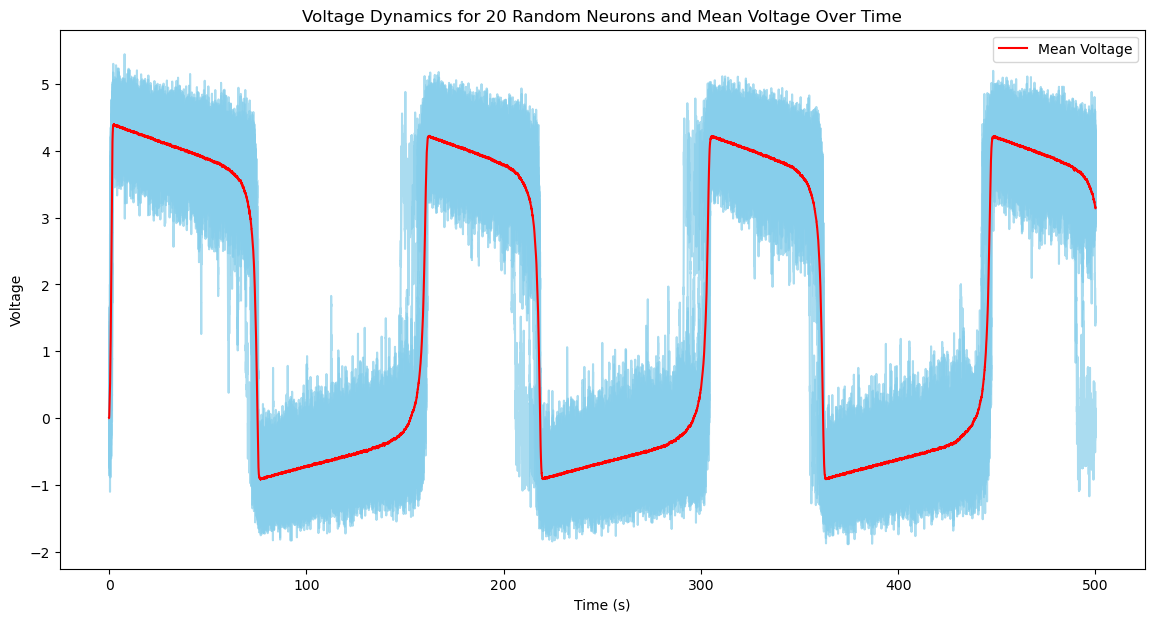

In [35]:
import matplotlib.pyplot as plt

# Randomly select 20 neurons
selected_neurons = torch.randint(0, n_neurons, (20,))

# Extract the data for the selected neurons
selected_v_rec = v_rec[:, selected_neurons].cpu().numpy()

# Compute the mean voltage for each time step
mean_v_rec = torch.mean(v_rec, dim=1).cpu().numpy()

# Time array for plotting
time_steps = dt * torch.arange(T).cpu().numpy()

# Plotting the individual neurons
plt.figure(figsize=(14, 7))
for neuron_data in selected_v_rec.T:
    plt.plot(time_steps, neuron_data, color='skyblue', alpha=0.7)

# Plotting the mean voltage in red
plt.plot(time_steps, mean_v_rec, color='red', label='Mean Voltage')

# Labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
# plt.ylim(-100, 100)
plt.title('Voltage Dynamics for 20 Random Neurons and Mean Voltage Over Time')
plt.legend()

# Show the plot
plt.show()
